# **Homework 2**
# **SHAP**
# MIMUW XAI WINTER 2022/2023

# Task A

In this homework we used brain stroke dataset from kaggle. First we trained XGBClassifier model and used packages dalex and shap to find variables of the highest importance. Found samples that differ on the highest importance variable and one having opposite attribution. Different model have similar results on chosen samples.

# Appendix

## 0. Setup

In [130]:
!pip install dalex shap catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 16 kB/s 


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd

import dalex as dx
import shap

In [59]:
df = pd.read_csv("brain_stroke.csv")
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


Dataset consists of features that are nonnumerical. Let's  hot encode them first.

In [60]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

features_2_one_hot = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

transformer = make_column_transformer(
    (OneHotEncoder(), features_2_one_hot),
    remainder='passthrough')

transformed = transformer.fit_transform(df)
df_one_hot = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names_out()
)
df_one_hot

,onehotencoder__gender_Female,onehotencoder__gender_Male,onehotencoder__ever_married_No,onehotencoder__ever_married_Yes,onehotencoder__work_type_Govt_job,onehotencoder__work_type_Private,onehotencoder__work_type_Self-employed,onehotencoder__work_type_children,onehotencoder__Residence_type_Rural,onehotencoder__Residence_type_Urban,onehotencoder__smoking_status_Unknown,onehotencoder__smoking_status_formerly smoked,onehotencoder__smoking_status_never smoked,onehotencoder__smoking_status_smokes,remainder__age,remainder__hypertension,remainder__heart_disease,remainder__avg_glucose_level,remainder__bmi,remainder__stroke
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,67.0,0.0,1.0,228.69,36.6,1.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,80.0,0.0,1.0,105.92,32.5,1.0
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,49.0,0.0,0.0,171.23,34.4,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,79.0,1.0,0.0,174.12,24.0,1.0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,81.0,0.0,0.0,186.21,29.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,41.0,0.0,0.0,70.15,29.8,0.0
4977,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,40.0,0.0,0.0,191.15,31.1,0.0
4978,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,45.0,1.0,0.0,95.02,31.8,0.0
4979,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,40.0,0.0,0.0,83.94,30.0,0.0


Preparing train and test samples.

In [61]:
X = df_one_hot.drop("remainder__stroke", axis=1)
y = df_one_hot.remainder__stroke
X_train, X_test, y_train, y_test =train_test_split( X, y, test_size=0.2, random_state=42)

In [72]:
X_train

,onehotencoder__gender_Female,onehotencoder__gender_Male,onehotencoder__ever_married_No,onehotencoder__ever_married_Yes,onehotencoder__work_type_Govt_job,onehotencoder__work_type_Private,onehotencoder__work_type_Self-employed,onehotencoder__work_type_children,onehotencoder__Residence_type_Rural,onehotencoder__Residence_type_Urban,onehotencoder__smoking_status_Unknown,onehotencoder__smoking_status_formerly smoked,onehotencoder__smoking_status_never smoked,onehotencoder__smoking_status_smokes,remainder__age,remainder__hypertension,remainder__heart_disease,remainder__avg_glucose_level,remainder__bmi
1652,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,26.00,0.0,0.0,168.15,22.9
1609,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,27.00,0.0,0.0,80.57,39.8
166,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,54.00,0.0,0.0,87.85,31.1
2488,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.00,0.0,0.0,92.30,14.8
3337,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,69.00,1.0,0.0,112.69,33.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,54.00,0.0,0.0,231.54,29.9
466,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,38.00,0.0,0.0,70.92,41.6
3092,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,13.00,0.0,0.0,90.60,16.9
3772,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.48,0.0,0.0,118.75,17.4


## 1. Training XGBoost classifier model

In [93]:
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
xgb_predict=xgb.predict(X_test)
xgb_acc=accuracy_score(xgb_predict,y_test)
model = xgb
xgb_acc

0.9448345035105316

## 2. Selecting two observations and calculating model's prediction

In [99]:
observations = [7,26]
predictions = model.predict(X_test.iloc[observations])
predictions

array([0., 0.])

## 3. Calculating the decomposition of predictions

### 3.1 shap

In [96]:
shap_explainer = shap.explainers.Tree(model, data=X, model_output="probability")

In [97]:
shap_values = shap_explainer(X)
shap_values

.values =
array([[ 3.00451289e-05,  0.00000000e+00, -1.24693197e-03, ...,
         4.38299006e-02,  6.59776905e-02,  6.76754334e-02],
       [ 1.55991024e-05,  0.00000000e+00, -2.04244181e-03, ...,
         3.73858577e-03,  1.54807161e-02, -9.82789044e-03],
       [-4.98065746e-05,  0.00000000e+00, -1.86722622e-04, ...,
        -8.94984138e-05,  2.00250362e-02, -1.05830761e-02],
       ...,
       [ 9.92403997e-05,  0.00000000e+00, -2.60742478e-04, ...,
        -3.52459615e-05, -7.26131552e-03,  3.68974870e-03],
       [-1.10158184e-07,  0.00000000e+00, -3.10397093e-04, ...,
        -3.98631350e-05, -4.00864774e-03,  1.59170192e-02],
       [ 3.43662236e-04,  0.00000000e+00, -3.91999733e-03, ...,
        -1.33359436e-04, -2.01893887e-02,  3.27846881e-02]])

.base_values =
array([0.05335685, 0.05335685, 0.05335685, ..., 0.05335685, 0.05335685,
       0.05335685])

.data =
array([[  0.  ,   1.  ,   0.  , ...,   1.  , 228.69,  36.6 ],
       [  0.  ,   1.  ,   0.  , ...,   1.  , 105.92,  

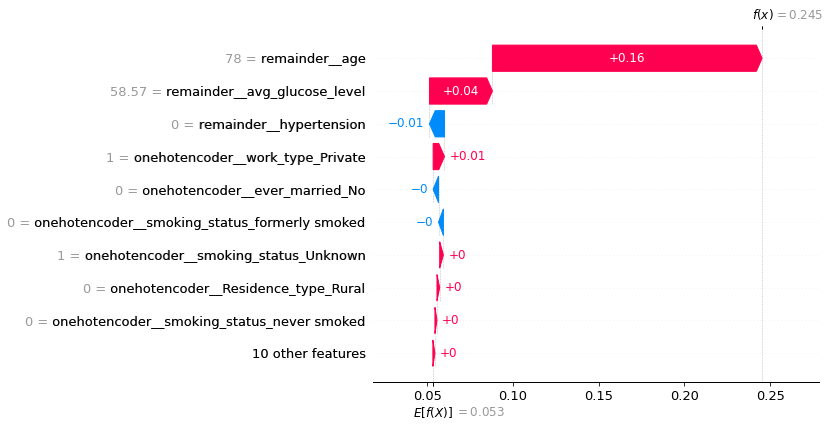

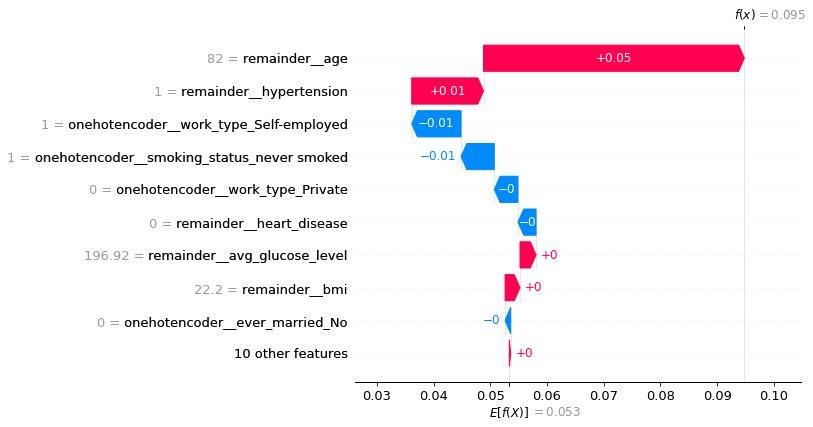

In [100]:
for i in observations:
    shap.plots.waterfall(shap_values[i])

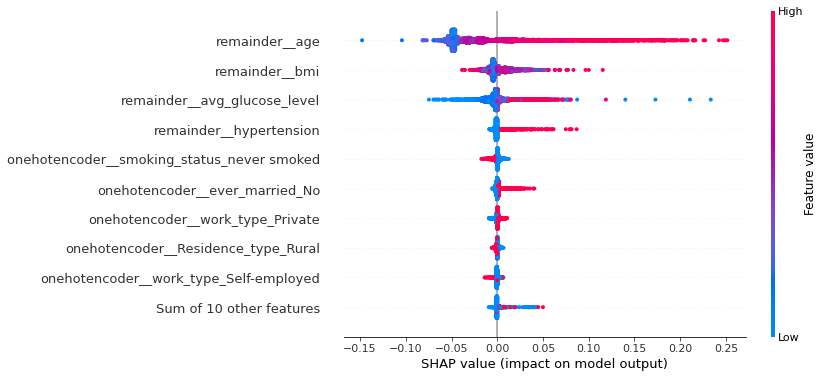

In [101]:
shap.plots.beeswarm(shap_values, max_display=10, plot_size=(9, 6))

### 3.2 dalex

In [109]:
model_predicting_method = lambda m, d: m.predict_proba(d)[:, 1]

explainer = dx.Explainer(model, X_train, y_train, predict_function=model_predicting_method, label="brain_stroke")

Preparation of a new explainer is initiated

  -> data              : 3984 rows 19 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3984 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : brain_stroke
  -> predict function  : <function <lambda> at 0x7ff146c14560> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000624, mean = 0.0487, max = 0.489
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.386, mean = 2.31e-06, max = 0.986
  -> model_info        : package xgboost

A new explainer has been created!


In [112]:
explainer.model_performance()

invalid value encountered in double_scalars


,recall,precision,f1,accuracy,auc
brain_stroke,0.0,0.0,NaN,0.95001,0.894921


In [111]:
def pf_xgboost_classifier_categorical(model, df):
    df.loc[:, df.dtypes == 'object'] =\
        df.select_dtypes(['object'])\
        .apply(lambda x: x.astype('category'))
    return model.predict_proba(df)[:, 1]

explainer = dx.Explainer(model, X, y, predict_function=pf_xgboost_classifier_categorical, label="brain_stroke")

Preparation of a new explainer is initiated

  -> data              : 4981 rows 19 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4981 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : brain_stroke
  -> predict function  : <function pf_xgboost_classifier_categorical at 0x7ff146c14950> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000624, mean = 0.0487, max = 0.525
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.525, mean = 0.0011, max = 0.999
  -> model_info        : package xgboost

A new explainer has been created!


In [114]:
explainer.predict(X_test.iloc[observations])

array([0.06181765, 0.0010808 ], dtype=float32)

In [115]:
shap_attributions = [explainer.predict_parts(X_test.iloc[[i]], type="shap", label=f'sample {i}') for i in observations]

In [127]:
shap_attributions[0].plot(shap_attributions[1::])

In [117]:
bd_attributions = [explainer.predict_parts(X.iloc[[i]], type="break_down", label=f'sample {i}') for i in observations]

In [118]:
bd_attributions[0].plot(bd_attributions[1::])

## 4. Looking for different variables of highest importance

In [ ]:
shap.plots.waterfall(shap_values[9])
shap.plots.waterfall(shap_values[8])

On the first sample hightest importance is *remainder_bmi* and on a second one it is *remainder_age*.

## 5. Looking for opposite attribution

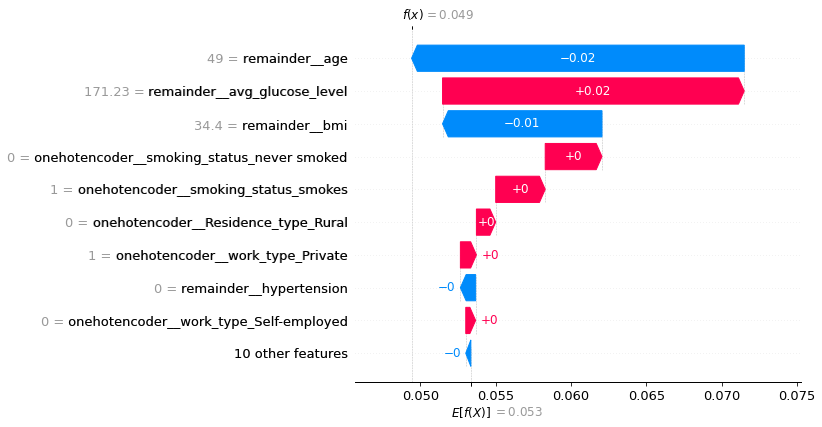

In [123]:
shap.plots.waterfall(shap_values[2])

Previous samples had positive attribution on *remainder_age*.

## 6. Comparing shap and dalex result

We can observe that dalex and shap returns different highest importance attribute.

## 7. 

In [132]:
from catboost import CatBoostClassifier
cat=CatBoostClassifier()
cat.fit(X_train,y_train)
cat_predict=xgb.predict(X_test)
cat_acc=accuracy_score(xgb_predict,y_test)
model = cat
cat_acc

Learning rate set to 0.01859
0:	learn: 0.6649419	total: 3.21ms	remaining: 3.21s
1:	learn: 0.6395406	total: 6.67ms	remaining: 3.33s
2:	learn: 0.6163820	total: 8.96ms	remaining: 2.98s
3:	learn: 0.5929330	total: 11.6ms	remaining: 2.88s
4:	learn: 0.5722530	total: 14.7ms	remaining: 2.92s
5:	learn: 0.5513043	total: 19.1ms	remaining: 3.16s
6:	learn: 0.5326619	total: 22.5ms	remaining: 3.19s
7:	learn: 0.5136295	total: 26.8ms	remaining: 3.32s
8:	learn: 0.4940388	total: 30.4ms	remaining: 3.34s
9:	learn: 0.4729194	total: 33.7ms	remaining: 3.34s
10:	learn: 0.4566971	total: 37ms	remaining: 3.32s
11:	learn: 0.4385522	total: 40.4ms	remaining: 3.32s
12:	learn: 0.4247723	total: 43.6ms	remaining: 3.31s
13:	learn: 0.4083701	total: 46.9ms	remaining: 3.31s
14:	learn: 0.3941886	total: 50ms	remaining: 3.29s
15:	learn: 0.3809191	total: 53.3ms	remaining: 3.28s
16:	learn: 0.3694541	total: 56.6ms	remaining: 3.27s
17:	learn: 0.3565855	total: 60.2ms	remaining: 3.28s
18:	learn: 0.3450669	total: 63.6ms	remaining: 3.2

0.9448345035105316

In [136]:
shap_explainer = shap.explainers.Tree(model, data=X_train, model_output="probability")

In [135]:
shap_values = shap_explainer(X_train)
shap_values

100%|===================| 4974/4981 [05:42<00:00]       

.values =
array([[ 0.01057983,  0.00865665,  0.00800403, ...,  0.10462546,
         0.15019146,  0.13119259],
       [ 0.01316798,  0.01582784,  0.0053268 , ..., -0.00717401,
         0.05809258,  0.04108883],
       [ 0.00766939,  0.00488448,  0.00444937, ...,  0.00238281,
         0.13428199,  0.02280447],
       ...,
       [ 0.00085989,  0.00170775,  0.0006431 , ...,  0.00063637,
        -0.00774994,  0.01166604],
       [-0.00106428, -0.00191533,  0.0005555 , ...,  0.00139718,
         0.00329034,  0.01590196],
       [-0.00196538, -0.00387077, -0.00017192, ...,  0.00233738,
        -0.01279588,  0.01811284]])

.base_values =
array([0.03535501, 0.03535501, 0.03535501, ..., 0.03535501, 0.03535501,
       0.03535501])

.data =
array([[  0.  ,   1.  ,   0.  , ...,   1.  , 228.69,  36.6 ],
       [  0.  ,   1.  ,   0.  , ...,   1.  , 105.92,  32.5 ],
       [  1.  ,   0.  ,   0.  , ...,   0.  , 171.23,  34.4 ],
       ...,
       [  1.  ,   0.  ,   0.  , ...,   0.  ,  95.02,  31.8 ],


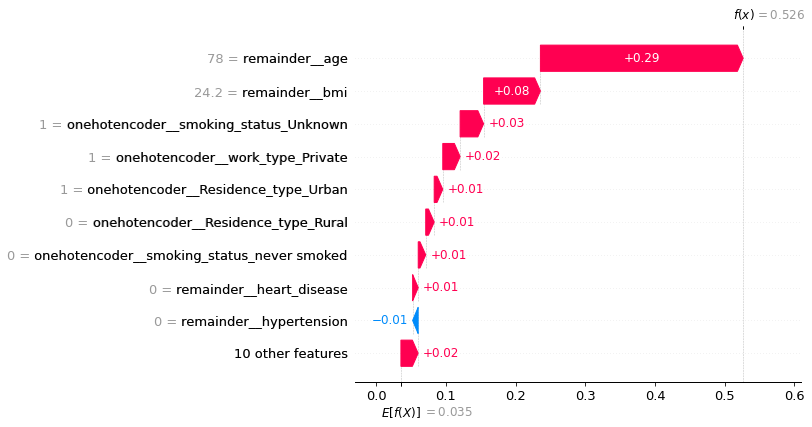

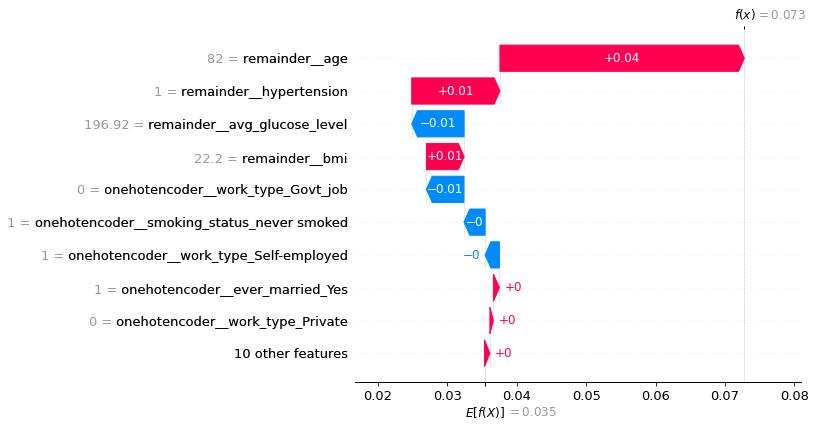

In [137]:
for i in observations:
    shap.plots.waterfall(shap_values[i])

# Task B

Given v function:
v() = 0
v(A) = 20
v(B) = 20
v(C) = 60
v(A,B) = 60
v(A,C) = 70
v(B,C) = 70
v(A,B,C) = 100

We have 6 permutations of ABC:
ABC,
ACB,
BAC,
BCA,
CAB,
CBA.

Let's check how adding A player changes value of coalition:\
v(A) - V({}) = 20 \
v(A,B) - V(B) = 40 \
v(A,C) - V(C) = 10 \
v(A,B,C) - V(B,C) = 30 \

Counting an average of difference of permutations: 

$\phi_A $ = 1 / 6 * (20 + 20 + 40 + 30 + 10 + 30) = 150/6 = 25

